In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from cmocean import cm
from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster() # necessary?
    w = cluster.scale(jobs=9)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58249 instead
  warnings.warn(


In [3]:
client

Client Scheduler: tcp://10.148.0.254:55927 Dashboard: http://10.148.0.254:58249/status,Cluster Workers: 49 Cores: 49 Memory: 782.53 GiB


_________
# 1. Read dataset (LLC4320 face 2, surface velocity field)


In [4]:
out_dir_work = '/home/datawork-lops-osi/equinox/mit4320/rechunked/'
ds_U = xr.open_zarr(out_dir_work+'SSU.zarr').rename({'i_g': 'i'}).isel(face=2)
ds_V = xr.open_zarr(out_dir_work+'SSV.zarr').rename({'j_g': 'j'}).isel(face=2)
ds = xr.merge([ds_U,ds_V])
ds

,Array,Chunk
Bytes,600.68 GiB,101.25 MiB
Shape,"(8640, 4320, 4320)","(240, 192, 576)"
Count,92737 Tasks,6624 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,600.68 GiB,101.25 MiB
Shape,"(8640, 4320, 4320)","(240, 192, 576)"
Count,92737 Tasks,6624 Chunks
Type,float32,numpy.ndarray


# 2. Filter

In [5]:
out_dir_zarr = '/home1/scratch/xyu/IGWs/'

def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

## (1) bandpass (M2 band)

In [6]:
lowcut = 1/13.8/3600
highcut = 1/11.2/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq
high = highcut/nyq

b, a = butter(4, [low, high], 'bandpass')

In [7]:
U_bandpass_filter = butter_filter(ds_U.SSU, b, a)
V_bandpass_filter = butter_filter(ds_V.SSV, b, a)

KE_bandpass_filter = 1025*(U_bandpass_filter**2 + V_bandpass_filter**2)/2 # KE
KE_bandpass_filter_tmean = KE_bandpass_filter.mean(['time'])
print(KE_bandpass_filter_tmean)

<xarray.DataArray (j: 4320, i: 4320)>
dask.array<mean_agg-aggregate, shape=(4320, 4320), dtype=float32, chunksize=(192, 576), chunktype=numpy.ndarray>
Coordinates:
    face     int64 2
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319


In [8]:
# It takes 10-20 mins
KE_bandpass_filter_tmean = np.real(KE_bandpass_filter_tmean).rename('KE_bandpass_filter_tmean')
file_out = out_dir_zarr+'/KE_m2_tmean.zarr'
KE_bandpass_filter_tmean.to_dataset().to_zarr(file_out, mode='w')   

## (2) bandpass (f band)

In [18]:
15.9*0.9

14.31

In [19]:
15.9*1.1

17.490000000000002

In [28]:
lowcut = 1/14.3/3600
highcut = 1/17.5/3600

fs = 1/3600
nyq = 0.5*fs
low = lowcut/nyq
high = highcut/nyq

b, a = butter(4, [low, high], 'bandpass')

In [29]:
U_bandpass_filter = butter_filter(ds_U.SSU, b, a)
V_bandpass_filter = butter_filter(ds_V.SSV, b, a)

In [30]:
KE_bandpass_filter = 1025*(U_bandpass_filter**2 + V_bandpass_filter**2)/2 # KE
KE_bandpass_filter_tmean = KE_bandpass_filter.mean(['time'])
print(KE_bandpass_filter_tmean)

<xarray.DataArray (j: 4320, i: 4320)>
dask.array<mean_agg-aggregate, shape=(4320, 4320), dtype=float32, chunksize=(192, 576), chunktype=numpy.ndarray>
Coordinates:
    face     int64 2
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319


In [31]:
KE_bandpass_filter_tmean = np.real(KE_bandpass_filter_tmean).rename('KE_bandpass_filter_tmean')
file_out = out_dir_zarr+'/KE_f_tmean.zarr'
KE_bandpass_filter_tmean.to_dataset().to_zarr(file_out, mode='w')   

__________
# Plots

In [32]:
ds_m2 = xr.open_zarr(out_dir_zarr+'KE_m2_tmean.zarr')
ds_f = xr.open_zarr(out_dir_zarr+'KE_f_tmean.zarr')

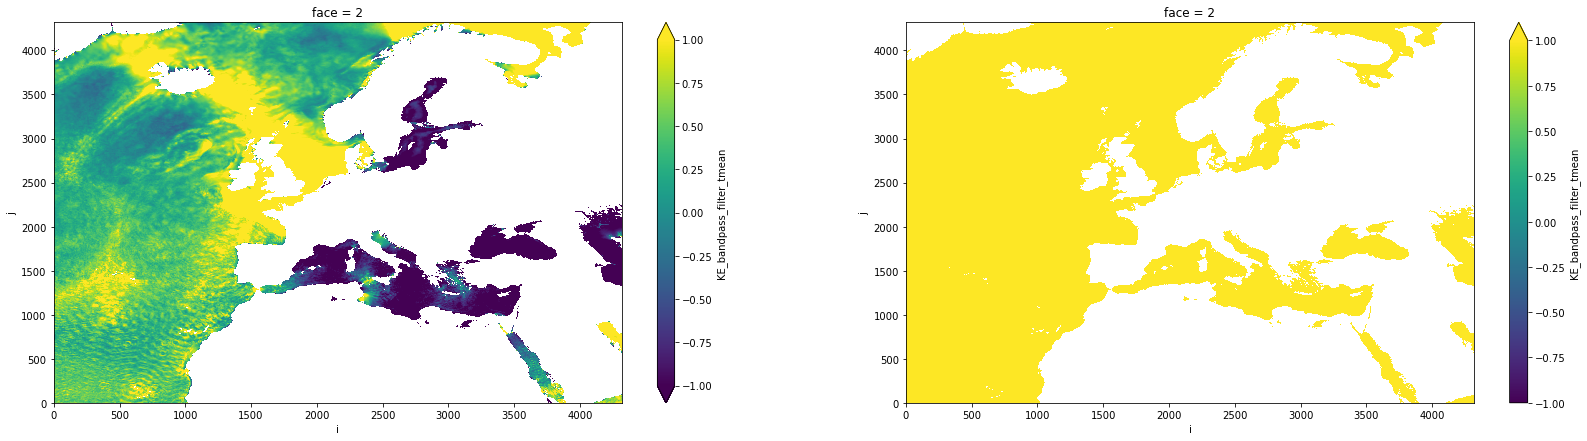

In [33]:
fig, ax = plt.subplots(figsize=(28,7))

ax = plt.subplot(121)
np.log10(ds_m2.KE_bandpass_filter_tmean).plot(vmin=-1,vmax=1)

ax = plt.subplot(122)
np.log10(ds_f.KE_bandpass_filter_tmean).plot(vmin=-1,vmax=1)

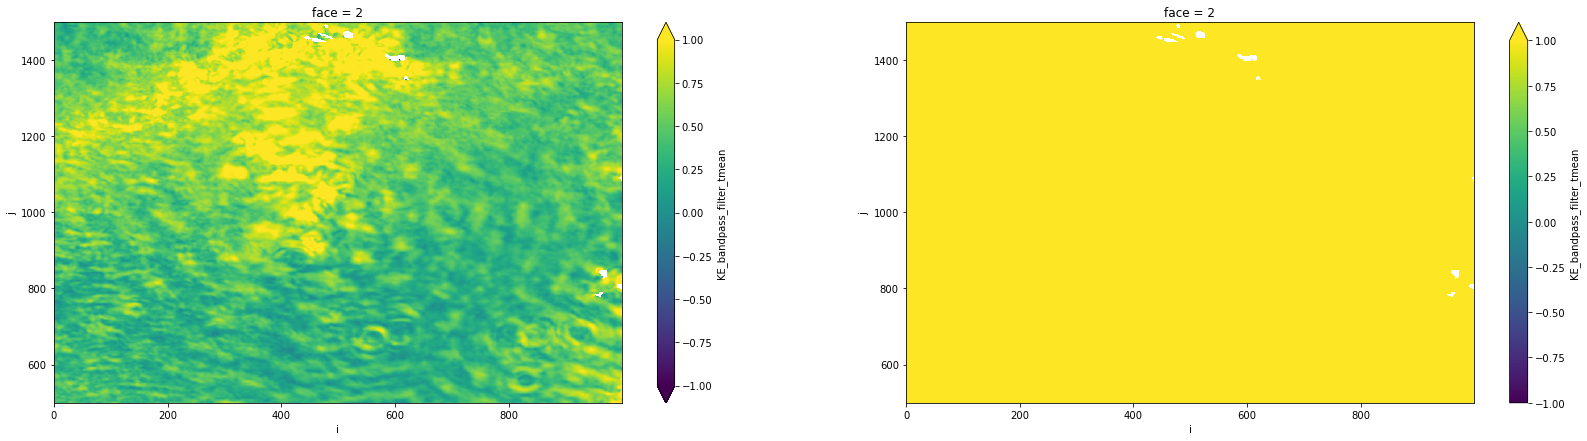

In [27]:
fig, ax = plt.subplots(figsize=(28,7))

ax = plt.subplot(121)
np.log10(ds_m2.KE_bandpass_filter_tmean).isel(i=slice(0,1000),j=slice(500,1500)).plot(vmin=-1,vmax=1)

ax = plt.subplot(122)
np.log10(ds_f.KE_bandpass_filter_tmean).isel(i=slice(0,1000),j=slice(500,1500)).plot(vmin=-1,vmax=1)

In [34]:
cluster.close()